# Organization
Because the 2 Tasks in this homework are not so heavy, we each developed our own code, and then compared our results and improved each solution together. The source codes written by Wu and Gao are presented and compared in the report.
In this report, Gao analysed the problem of Task 1 and described our approaches to solve the problem, Wu for Task 2, and Wei gave a discussion and summarization.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import time
from homework1.Homework_1_function_headers_group4 import guided_modes_1DTE_wu as wu_1D
from homework1.Homework_1_function_headers_group4 import guided_modes_1DTE_gao as gao_1D
from homework1.Homework_1_function_headers_group4 import guided_modes_2D_wu as wu_2D
from homework1.Homework_1_function_headers_group4 import guided_modes_2D_gao as gao_2D

In [2]:
#global parameters
lam = 0.78
k0 = 2*np.pi/lam
e_substrate = 2.25
delta_e = 1.5e-2
w = 15.0

# Task 1
Our task is to implement a finite difference mode solver. And in the 1D case we first use the discretization of the linear differential operator

$$L = \frac{1}{k}\frac{d^2}{dx^2}+\varepsilon(x)$$

which is in eigenvalue equation
$$LE(x) = \varepsilon_{eff}E(x)$$

In order to make calculation easier, we approximate the second order derivative using a finite difference scheme. We use the discretized eigenmodes of the permittivity distribution from this matrix. The source code in 1D mode solver can be found in file 'Homework_1_function_headers_group_4'.

First we approximate the second-order derivatives with a symmetric finite difference scheme, which results in a tridiagonal matrix. This matrix first defines the primary and secondary diagonal's and then will be assembled into an operator matrix using the primary and secondary diagonals. The diagonal matrix is created using `np.diag` and its offset to the main diagonal is defined. The `np.linalg.eig` function is then used to calculate the eigenvalues and eigenvectors. Then define a perfect conducting boundary where that the edges of the discrete field vector are zero. And the effective permittivity functions corresponding to the eigenvalues and eigenvectors are arranged in descending order.

We set the substrate $\varepsilon = 2.25$, $W = 15\mu m$, $\lambda = 0.78\mu m$, and we select the guided modes whose eigenvalue are larger than the substrate permittivity but smaller than the maximum of the dielectric permittivity in the x-direction. In our test, the two groups of selected eigenvalues and guided modes created by Wu's and Gao's method are equal, and the eigenvalues are shown below. The corresponding eigen modes are plotted in Fig. 1.

In [3]:
# Test parameters for Task 1 (length unit in µm)
grid_size = 120
number_points = 601
h = grid_size/(number_points - 1)
xx = np.linspace( -grid_size/2, grid_size/2, number_points )
prm = e_substrate + delta_e * np.exp(-(xx/w)**2)

In [4]:
#| echo: true
eff_eps_wu, guided_wu = wu_1D(prm, k0, h)
eff_eps_gao, guided_gao = gao_1D(prm, k0, h)

e_max = prm.max()
idx_wu = (eff_eps_wu < e_max) & (eff_eps_wu > e_substrate)
idx_gao = (eff_eps_gao < e_max) & (eff_eps_gao > e_substrate)
eff_eps_wu_selected = eff_eps_wu[idx_wu]
eff_eps_gao_selected = eff_eps_gao[idx_gao]

print("Are the two groups of eigenvalue equal?:",
      np.allclose(eff_eps_wu_selected, eff_eps_gao_selected))
print("The selected eigenvalues are:", "\n", eff_eps_wu_selected)
print("Are the two groups of eigen vector equal?:",
      np.allclose(guided_wu[:, idx_wu], guided_gao[:, idx_gao]))

Are the two groups of eigenvalue equal?: True
The selected eigenvalues are: 
 [2.26401269 2.26209061 2.2602771  2.2585761  2.25699259 2.25553247
 2.25420314 2.253014   2.25197792 2.25111336 2.25045026 2.25004584]
Are the two groups of eigen vector equal?: True


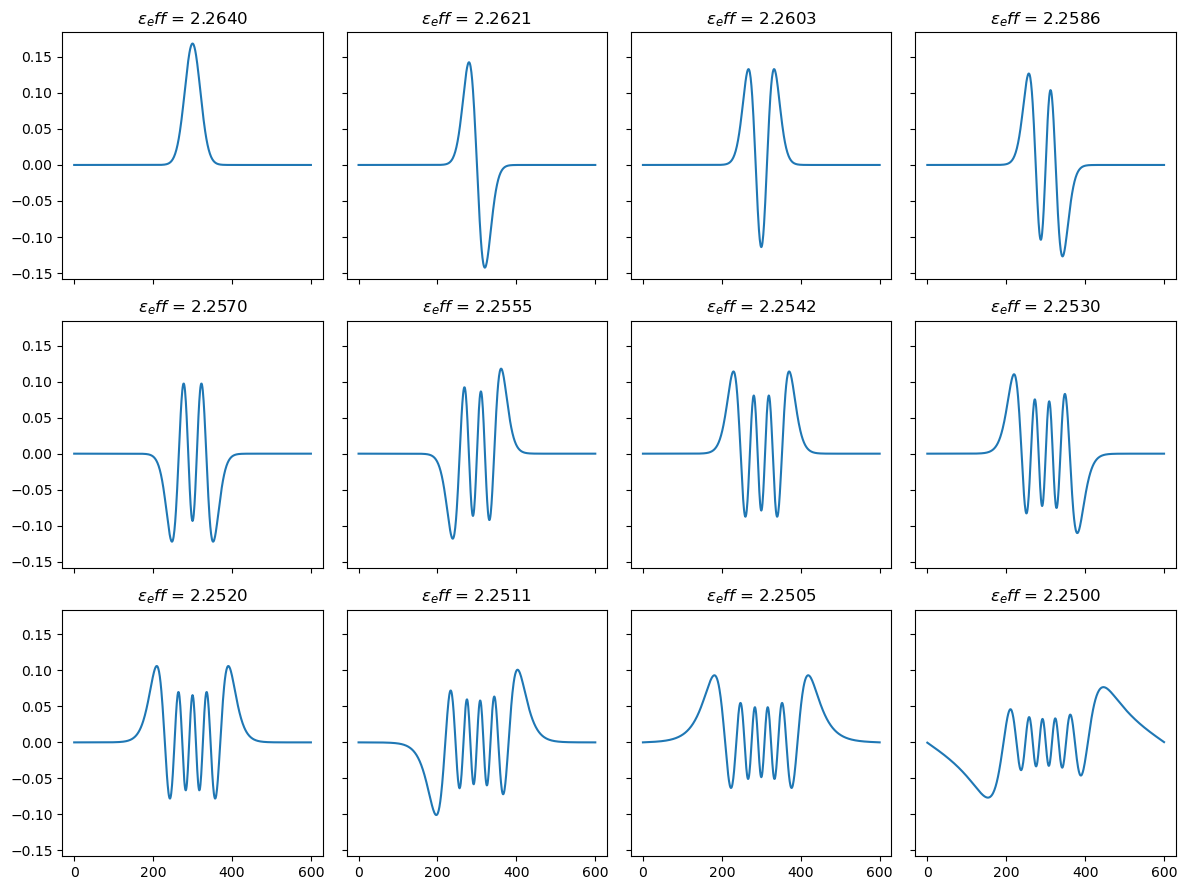

In [13]:
#| layout-ncol: 1
#| fig-cap:
#|   - "Guided modes by wu's implementation"
fig, axes = plt.subplots(3, 4, figsize=(12, 9), sharex='all', sharey='all')
for i, ax in enumerate(axes.flatten()):
      ax.plot(guided_gao[:,idx_gao][:,i])
      ax.set_title(r'$\varepsilon_eff$ = %.4f'%eff_eps_gao_selected[i])
plt.tight_layout()

Amongst other things we have to pay attention to the effect that changes in grid size have on the field. This is because the decay rate of the field is exponentially related to the distance. The choice of grid size is therefore also important. Therefore, the choice of h needs to be made carefully. And our assumption of a perfect electric conductor may also be different from the real situation. Therefore, the choice of h needs to be made with care.

<div class="alert alert-block alert-success">
Good point. It is also recommended to always do a convergence test for it.
</div>

\newpage
# Task 2

Task 2 is an extension of Task 1. In this task we need to solve the eigenvalue problem for scalar fields by a finite difference scheme.
we write the Laplace operator in individual cartsian components
$$[\frac{\partial^2}{\partial x^2}+\frac{\partial^2}{\partial y^2}]u(x,y)+[k0^2\varepsilon(x,y,\omega)-\beta^2(\omega)]u(x,y)=0$$

We transform it to standard notation
$$[\frac{\partial^2}{\partial x^2}+\frac{\partial^2}{\partial y^2}+k0^2\varepsilon(x,y,\omega)]u(x,y)=\beta^2(\omega)u(x,y)$$

The Laplace operator can be approximated by a discrete opterator:
$$\frac{\partial^2u(x,y)}{\partial x^2} \approx \frac{u(x-h,y)-2u(x,y)+u(x+h,y)}{h^2}$$
$$\frac{\partial^2u(x,y)}{\partial x^2} \approx \frac{u(x,y-h)-2u(x,y)+u(x,y+h)}{h^2}$$

Thus,  the complete eigenvalue problem in discrete notation can be summarized as
$$\frac{u_{j+1,k}+u_{j-1,k}+u_{j,k+1}+u_{j,k-1}-4u_{j,k}}{h^2}+k_{j,k}^2(\omega)u_{j,k}=\beta^2(\omega)u_{j,k}$$

To solve this eigenvalue problem, we need to at first unfold the 2D variable $u_{j,k}$ to a 1D vector. Thus, we have to unfold the corresponding 2D dielectric permittivity to 1D vector. There are two ways to unfold $u_{j,k}$, alone row and alone colum. Our group test both 2 ways, and their results are equivalent. In Wu's implementation, `np.flatten` is used to unfold prm alone row, and in Gao's implementation, `np.ravel` with parameter order=F is used to alone colum.

![Discrete Laplace operator](Laplace_operator.jpeg){width=70%}

The difficult points of this task are create the Laplace operator and solve the eigenvalue problem efficiently. To create the Laplace operator, we first need to figure out what components are in the Laplace operator. The discrete Laplace operator is shown in Fig. 2. The numbers on the blue lines are the differentiation with respect to x (as same as the tridiagonal matrix in 1D case). The numbers on the magenta line respect to $u_{j,k+1}$ and on the yellow line respect to $u_{j,k-1}$. Hence, to we assign values to magenta and yellow lines, we can set the parameter offset in `np.diag` to n and -n, where n is the number of colum if prm is unfolded alone row.

Generally, the size of operator matrix M is very huge, in this task is more than 90000 $\times$ 90000, it's almost impossible for a personal computer to solve the eigenvalue problem of it. Fortunately, the sparsity of our operator matrix is about 0.0055%, we apply the `scipy.sparse` package to creat the operator matrix and solve the eigenvalue problem, which can highly improve the computation efficiency. `sps.spdiags` and `sps.dia_array` are used in wu's and gao's implementation to create the sparse operator matrix. The `sps.linalg.eigs` function is then used to calculate the eigenvalues and eigenvectors. To reduce computation time, we just calculate the largest 10 eigenvalues and eigenvectors, which contain the most information of our operator matrix.
Finally, we reshape each eigenvector back to its original size.

In [6]:
#2D Example Parameters
grid_size = 120
number_points = 301
numb = 10
h = grid_size/(number_points - 1)
xx = np.linspace(-grid_size/2-h,grid_size/2+h,number_points+2)
yy = np.linspace(-grid_size/2,grid_size/2,number_points)
XX,YY = np.meshgrid(xx,yy)
prm = e_substrate + delta_e * np.exp(-(XX**2+YY**2)/w**2)

In [7]:
start = time.time()
eff_eps2d_wu, guided2d_wu = wu_2D(prm, k0, h, numb)
end = time.time()
time_wu = end - start

In [8]:
start = time.time()
eff_eps2d_gao, guided2d_gao = gao_2D(prm, k0, h, numb)
end = time.time()
time_gao = end - start

To test our implementation, $\varepsilon$, W, and wavelength are set to 2.25, $15\mu m$, and $0.78\mu m$. After applying `scipy.sparse` package, the computation time drastically reduce to under 3s. Two implementations gave a same result in eigenvalues calculating. The largest 10 eigenvalues are shown below. The absolute value of guided modes by Wu's and Gao's method are shown in Fig. 3 and 4. The guided modes created by the two implementations are numerically equal but have a rotation.

In [9]:
#| echo: true
print("Running time of wu's method", time_wu)
print("Running time of gao's method", time_gao)
print("Are the two groups of eigenvalue equal?:",
      np.allclose(eff_eps2d_wu, eff_eps2d_gao))
print("The largest 10 eigenvalues are:", "\n", eff_eps2d_gao.real)

Running time of wu's method 2.886117696762085
Running time of gao's method 2.462636947631836
Are the two groups of eigenvalue equal?: True
The largest 10 eigenvalues are: 
 [2.26304305 2.26115868 2.26115868 2.2594208  2.25935066 2.25934865
 2.25776268 2.25761929 2.25776268 2.25761929]


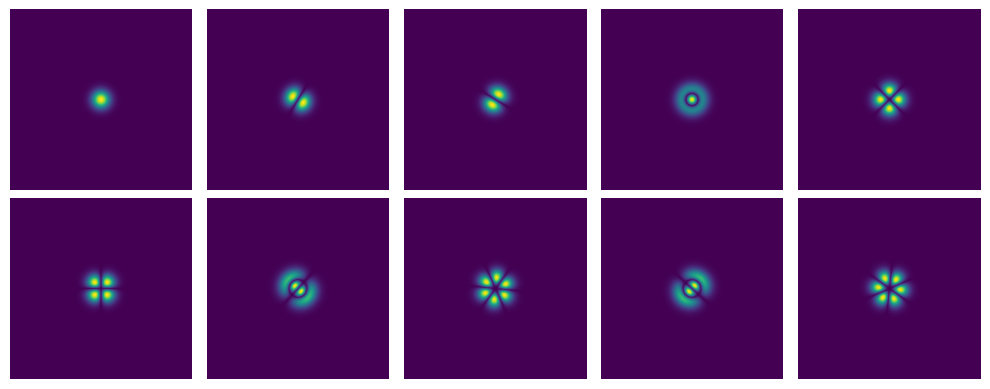

In [10]:
#| layout-ncol: 1
#| fig-cap:
#|   - "Guided modes by wu's implementation"
fig, axes = plt.subplots(2, 5, figsize=(10, 4))
for i, ax in zip(range(10), axes.flatten()):
      ax.imshow(np.abs(guided2d_wu[:,:,i]))
      ax.axis('off')
plt.tight_layout()

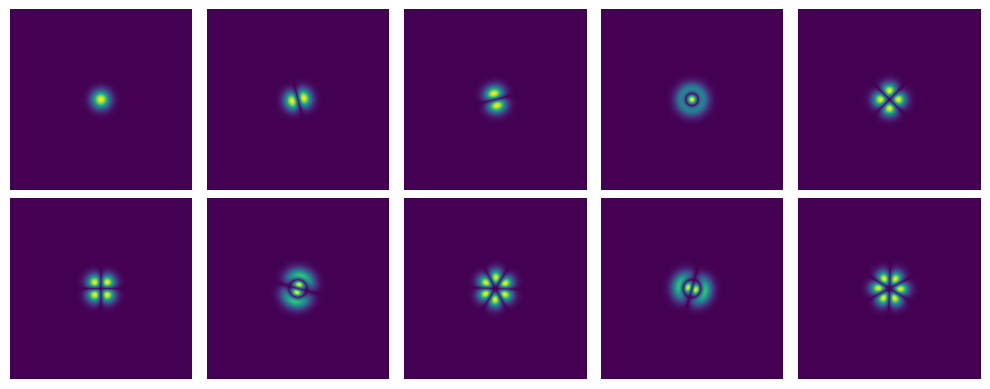

In [11]:
#| layout-ncol: 1
#| fig-cap:
#|   - "Guided modes by gao's implementation"
fig, axes = plt.subplots(2, 5, figsize=(10, 4))
for i, ax in zip(range(10), axes.flatten()):
      ax.imshow(np.abs(guided2d_gao[i,:,:]))
      ax.axis('off')
plt.tight_layout()

\newpage
# Discussion

1. Results
  * Task 1
In Fig.1, the patterns of permitted modes are shown. Two major features can be observed: First, the mode number is negatively related to the effective permitivity. As the mode number increase, or as the number of standing points inside the core, the effctive permitivity of goes downwards. Second, the absolute value of field negatively related to the number of modes. The peak value of largest is less than 1/3 of first's. One more noticable is the leakage of field.  The more complex the field, the less constrain of the core. The mode with largest mode number even leak its field to the claddings.
  * Task 2
As we can observe in Fig. 3 and Fig. 4, both codes clearly shown the patterns of largest propagation constant. Not surprisingly, the patterns are monopoles ($\text{LP}_{01}$, $\text{LP}_{02}$), dipoles($\text{LP}_{11}$, $\text{LP}_{12}$), quadrupole($\text{LP}_{21}$) and hexapole ($\text{LP}_{31}$) and each multipole mode has two orthogonal field distributions, which is consistant with analytical solutions of exponential core of wave fiber. The constraining behaviour of Electric field also demonstrated in figures. The lower mode numbers are, the more field are constrained in side the core radius "W". Comparing with monopole pattern, the field in hexapole pattern "leaks" more field outside the core of fiber.
However, there is tiny rotational difference between the same patterns. This could be from different reshaping methods. In Gao's method, each mode is reshaped by:
```
guided[i, :, :] = np.reshape(eigvecs[:, i], (NX, NY), order='F')
```
while Wu, on the other hand, reshapes directly:
```
guided = np.reshape(guided, (m, n, numb))
```


2. Disscussion
Due to limited time of author for disscusion chapter and the overall complexity of implmentation, our code and model still have a great room for improvement. Here are some work could be done:

  * Choice of Discretisation Degree
  The Discretasation degree, as stated above, deserves carefull choice and more sound justification. Too tiny grid may lead to abnormal behaviour of solver, enhance the compuational error, or uselessly waste the computational resources. While coarse gird results in bad simulational behaviours. A more plausable way is to set a threshold and to try a spectrum of grid numbers and comparing their results, unitl find two upper and lower limits that refining the choice of gird number into a suitable range. For example, if the difference of propagation constants between 1000 grid and 1100 gird is less than 1e-6, then 1000 gird discretisation could be set as a upper limit. Similarly, if the differnce between 300 grid and 200 grid greater than 1e-3, than a lower limit could be determined.
  The value we chose for Task 1 and 2, 600 and 300 respectively, are enough for homework 1. However, a more balanced value could be obtained after further examination in this manner.

  * Choice of Boundary Condition
  In our lecture scipts, Task 1&2, the boundary condition are assumed to be perfectly reflective, i.e. Assuming that the field is zero at the boundary of the computation domain in transverse direction (x,y-direction). However for more realistic boundaries, it could be absorbing (ABC), transparent (TBC) or perfectly matched (PML). Thus, a simple 0 evalutation of specific entries in matrix no longer suitable for this case. A good method is to create a seperate function as Boundary Condition switch. The raw matrix could be modified to serve for difference Boundaries conditions by calling the function with corresponding args of Boundary. A better version of homework 1 could be done after learning detail of Chapter 5 in lecture scripts.

  * Full Vectorial Representation of Electric Field in Task 2
  The real world Electric field is a 3d vector. Thus, a better field distribution could be computed by considering all other two dimensions. By using the Yee grid that preserve the inverse symmetry, the Maxwell Equations of E field and B field could be represented in discrete domain.

$$
\mathbf{U}_x = \frac{1}{\Delta x}\begin{bmatrix}
 -1& 1 &   & \\
 & -1 & 1 &  \\
 &  & \ddots  & \ddots \\
 &  &  & \ddots
\end{bmatrix}
$$
$$
\mathbf{U}_y = \frac{1}{\Delta y}\begin{bmatrix}
 -1& \cdots  & 1  & \\
 & -1 & \cdots  & 1 \\
 &  & \ddots  & \vdots \\
 &  &  & \ddots
\end{bmatrix}
$$

$$
\mathbf{V}_x = \frac{1}{\Delta x}\begin{bmatrix}
 1&  &   & \\
 -1& 1 &  &  \\
 & -1 & \ddots  & \\
 &  & \ddots & \ddots
\end{bmatrix}
$$

$$
\mathbf{V}_y = \frac{1}{\Delta x}\begin{bmatrix}
 1&  &   & \\
 \vdots & 1 &  &  \\
 -1& \cdots  & \ddots  & \\
 &  -1& \cdots  & \ddots
\end{bmatrix}
$$
Besides, the permitivities in discrete domian are sampled by spacically average:
$$
\varepsilon_{rx} = \frac{\varepsilon_r(j,l) + \varepsilon_r(j,l-1)}{2}
$$
$$
\varepsilon_{ry} = \frac{\varepsilon_r(j,l) + \varepsilon_r(j-1,l)}{2}
$$
$$
\varepsilon_{rz} = \frac{\varepsilon_r(j,l) + \varepsilon_r(j-1,l-1) + \varepsilon_r(j-1,l) + \varepsilon_r(j,l-1)}{4}
$$
And the full matrix representation is:
$$
ik_0\begin{bmatrix}
\mathbf{H_x}\\
\mathbf{H_y}\\
\mathbf{H_z}
\end{bmatrix}
=
\begin{bmatrix}
0 & -i\beta \mathbf{I} &\mathbf{U}_y \\
\beta \mathbf{I} & 0 & -\mathbf{U}_x\\
 -\mathbf{U}_y& \mathbf{U}_x & 0
\end{bmatrix}
\begin{bmatrix}
\mathbf{E_x}\\
\mathbf{E_y}\\
\mathbf{E_z}
\end{bmatrix}
$$

$$
ik_0
\begin{bmatrix}
\mathbf{\varepsilon}_{rx} & 0 & 0\\
0 & \mathbf{\varepsilon}_{ry} & 0\\
 0& 0 & \mathbf{\varepsilon}_{rz}
\end{bmatrix}
\begin{bmatrix}
\mathbf{E_x}\\
\mathbf{E_y}\\
\mathbf{E_z}
\end{bmatrix}
=
\begin{bmatrix}
0 & -i\beta \mathbf{I} &\mathbf{V}_y \\
\beta \mathbf{I} & 0 & -\mathbf{V}_x\\
 -\mathbf{V}_y& \mathbf{V}_x & 0
\end{bmatrix}
\begin{bmatrix}
\mathbf{H_x}\\
\mathbf{H_y}\\
\mathbf{H_z}
\end{bmatrix}
$$
Here, no quasi TE or quasi TM assumption applies. The full vectorial rep of field distribution could be computed, if compuational resources sufficient.

<div class="alert alert-block alert-success">
Very nice work! The implementation is accurate and I like particularly the result and discussion part. Here are some feedbacks: </br>
1. As you discussed in the first bulletin point of results, lower order mode has higher eff. permittivity and is more confined to the core. These features are all self-consistence, because the more the wave is confined, the larger the portion of the wave that is experiencing the permittivity at the core, and also the less structure is can have due to the tight confinement. </br>
2. Regarding the absolute value of the field, I would understand it as only a result of the normalization, since the absolute value of an eigenmode is not meaningful. </br>
3. I have also observed this rotation of symmetry of the modes also in other students' works. I still haven't figured out why is there a rotation. Do you have further explanation on this issue? </br>
4. You made a very good point that one should do test to find an optimal h. Instead of having two people writing the functions individually for cross-checking, you can also consider spending some labour on doing some convergence test or optimization next time. </br>
5. It is true that a PML boundary should better represent our system, however, PML boundary is much more complicated to implement than PEC. For such small project, a more feasible way to validate our approximation with PEC is to do a test, where one increases the grid size until no significant change in the result is observed. </br>
6. We know that the scalar approximation is just an approximation. But how bad (or how good) is the approximation in a particular case? Do you have a way to quantify it? </br>
</div>

<div class="alert alert-block alert-warning">
Figures can be labelled better. e.g. adding axes ticks, labels, colorbars.
</div>